# Input files for MITgcm runs
Generates the input files in binary format for MITgcm simmulations of the front observed by SODA deployment 2.

In [1]:
# load packages
from scipy import signal, interpolate
from scipy.optimize import curve_fit, fsolve
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import gsw
import os
from copy import copy

# files and paths
datapath = '/home/Marion.Alberty/projects/Arctic/front_SODA_lowres/data/'
datain = datapath + 'deployment2.mat'
# output file type
tp = '>f8'

## Model grid
Model domain and resolution are set by the variables $L(x,y,z)$ and $N(x,y,z)$, respectively. Both are dictionaries and the integer values can be easily changed to adjust the model grid and domain. Domain ($L$) units are given in *km, km, m*. The along-front direction is $x$, across-front is $y$, and vertical is $z$. Grid spacing is uniform in the along-front direction and non-uniform in the across-front and vertical.

In [2]:
# Set domain and resolution
L = {'x': 10, 'y': 30, 'z': 150}
N = {'x': 50, 'y': 50, 'z': 25}

# Calculate x grid
x = {'G':np.linspace(0,L['x'],N['x']+1)}
# At the grid centers
x['C'] = x['G'][0:-1] + np.diff(x['G'])/2

## Read in deployment data

In [3]:
# read in data file
ds = sio.loadmat(datain)
# Flatten 1-D variables
ds['y'] = ds['y'].flatten()
ds['z'] = ds['z'].flatten()
ds['lat'] = ds['lat'].flatten()
ds['lon'] = ds['lon'].flatten()

## Determine background profile

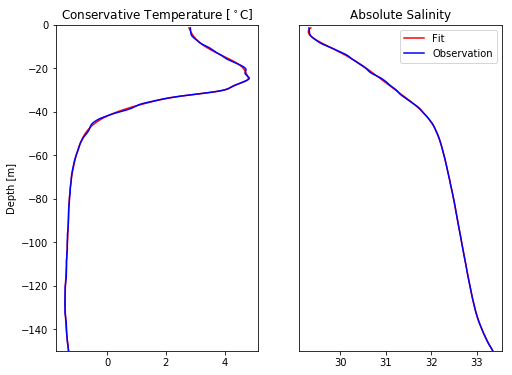

In [4]:
# Average over first half of data
ind = round(ds['y'].size/2)-1
# Make window for smoothing
b = signal.windows.hann(11)
# Get mean CT
ds['CT_bar'] = signal.filtfilt(b,b.sum(),np.mean(ds['CT'], axis=1))
# Get mean SA
ds['SA_bar'] = signal.filtfilt(b,b.sum(),np.mean(ds['SA'], axis=1))

# Determine high order fits to temperature and salinity profiles for easy scaling
# Temperature, sum of gaussians
def T_func(x,a1,b1,c1,a2,b2,c2,a3,b3,c3,a4,b4,c4,a5,b5,c5,a6,b6,c6):
    return a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + \
            a3*np.exp(-((x-b3)/c3)**2) + a4*np.exp(-((x-b4)/c4)**2) + \
            a5*np.exp(-((x-b5)/c5)**2) + a6*np.exp(-((x-b6)/c6)**2)
# Sallinity, sum of sin and cos
def S_func(x,a0,a1,b1,a2,b2,a3,b3,a4,b4,a5,b5,a6,b6,a7,b7,a8,b8):
    w = np.pi/(np.max(x)-np.min(x))
    return a0 + a1*np.cos(x*w) + b1*np.sin(x*w) + a2*np.cos(2*x*w) + b2*np.sin(2*x*w) + \
            a3*np.cos(3*x*w) + b3*np.sin(3*x*w) + a4*np.cos(4*x*w) + b4*np.sin(4*x*w) + \
            a5*np.cos(5*x*w) + b5*np.sin(5*x*w) + a6*np.cos(6*x*w) + b6*np.sin(6*x*w) + \
            a7*np.cos(7*x*w) + b7*np.sin(7*x*w) + a8*np.cos(8*x*w) + b8*np.sin(8*x*w)

# Estimate coefficients
popt_T, pcov_T = curve_fit(T_func, ds['z'], ds['CT_bar'])
popt_S, pcov_S = curve_fit(S_func, ds['z'], ds['SA_bar'])

# plot mean profiles
plt.figure(1,figsize=(8,6))
plt.subplot(121)
plt.plot(T_func(ds['z'],*popt_T),ds['z'],'r',ds['CT_bar'],ds['z'],'b')
plt.ylabel('Depth [m]')
plt.ylim(-L['z'],0)
plt.title('Conservative Temperature [$^\circ$C]')

plt.subplot(122)
plt.plot(S_func(ds['z'],*popt_S),ds['z'],'r',ds['SA_bar'],ds['z'],'b')
plt.ylim(-L['z'],0)
plt.yticks([])
plt.title('Absolute Salinity')
plt.legend(('Fit','Observation'))

plt.show()

## Determine scales and parameters for front
- $L_f$: Frontal width
- $dT,dS$: Frontal temperature and salinity gradient
- $H1$: Depth of the mixed layer front
- $dh$: Thickness of the mixed layer pycnocline

In [5]:
# Frontal width
Lf = ds['y'][-1]/4

# Horizontal gradient in mixed layer
# Sort first and last profiles
ind0 = np.argsort(ds['SA'][:,0])
indN = np.argsort(ds['SA'][:,-1])
# First profile
SA0 = ds['SA'][ind0,0]
CT0 = ds['CT'][ind0,0]
# Last profile
SAN = ds['SA'][indN,-1]
CTN = ds['CT'][indN,-1]
# Calc surface gradients
dT = CTN[0] - CT0[0]
dS = SAN[0] - SA0[0]

# Get depth of shallow mixed layer
ind_sML = np.argmax(SAN - SAN[0] > 0.1)
h_sML = ds['z'][ind_sML]
# Get depth where vertical gradient equals horizontal
ind_bML = np.argmax(SAN - SAN[0] > -dS)
h_bML = ds['z'][ind_bML]

# Layer 1 thickness [m]
H1 = -(h_sML + h_bML)/2
# Thickness of mixed layer pycnocline [m]
dh = -(h_bML - h_sML)/2

## Make Y grid
The across-front spacing concentrates resolution around the front with the form: $$ \Delta y(n) = A - B \mathrm{sech} ^2(C(n+D))$$ for $n \in [0, N_y-1]$.
Coefficients are chosen to aproximate desired frontal structure.
Relax to coarse resolution near the sides: $$A = \Delta y_{max}$$
Finest resolution near the front: $$B = \Delta y_{max} - \Delta y_{min}$$ $$D = -\frac{N_y-1}{2}$$
Numerically solve for $C$, which controls the width of the tranistion around the front, such that: $$\int_{0}^{N_y-1} \Delta y(n) dn = L_y$$ This ensures that the sum of $\Delta y$ is nearly $L_y$. The following equation is solved: $$L_y = A(N_y-1) - \frac{B}{C}[\tanh(C(N_y-1+D)) - \tanh(CD)]$$

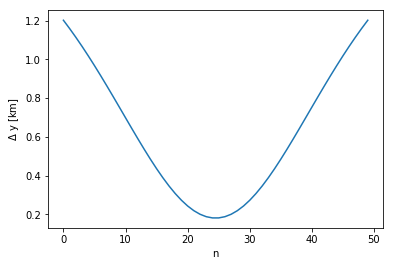

In [6]:
# Get min and max resolution
delY_min = 3*Lf/N['y']
delY_max = 3*L['y']/N['y']
# Set coefficients for delY
A = delY_max
B = delY_max - delY_min
D = -(N['y']-1)/2
# Define function
func = lambda C : A*(N['y'] - 1) - (B/C)*(np.tanh(C*(N['y'] - 1 + D)) - np.tanh(C*D)) - L['y']
# Solve for C
C_initial = -0.1 # Determined by plotting and looking for zero crossing
C = fsolve(func, C_initial)

# Solve original equation for delY
n = np.arange(0,N['y'])
delY = (A - B*(np.cosh(C*(n+D))**-2))*1000
# Calculate y from delY
# At the grid faces
y = {'G':np.append([0], np.cumsum(delY)/1000)}
# At the grid centers
y['C'] = y['G'][0:-1] + np.diff(y['G'])/2

# Plot delY
plt.plot(n,delY/1000)
plt.xlabel("n")
plt.ylabel("$\Delta$ y [km]")
plt.show()

## Make Z grid
Vertical grid spacing concentrates resolution near the surface with the form: $$ \Delta z(n) = A + \cosh(Bn)$$ for $n \in [0, N_z-1]$. Coeffients are determined to acheive fine resolution of $\Delta z_{min}$ near the surface: $$ A = \Delta z_{min} - 1$$
Numerically solve for $B$, such that $$\int_{0}^{N_z-1}\Delta z(n) = L_z$$ This ensures that the sum of $\Delta z$ is nearly $L_z$. The following equation is solved: $$L_z = A(N_z-1) + \frac{1}{B}\sinh(B(N_z-1))$$


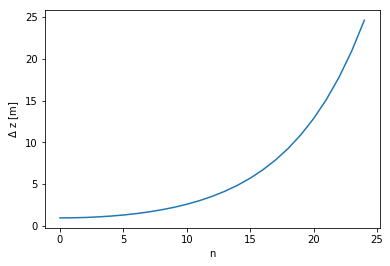

In [7]:
# Get min resolution
delZ_min = 2*H1/N['z']
# Set coefficients for delZ
A = delZ_min - 1
# Define function to solve for B
func = lambda B : A*(N['z'] - 1 ) + np.sinh(B*(N['z']-1))/B - L['z']
# Solve for B
B_initial = -0.15 # Determined by plotting and looking for zero crossing
B = fsolve(func, B_initial)

# Solve original equation for delZ
n = np.arange(0,N['z'])
delZ = A + np.cosh(B*n)
# Calculate z from delZ
# At the grid faces
z = {'G': -1*np.append([0], np.cumsum(delZ))}
# At the grid centers
z['C'] = z['G'][0:-1] + np.diff(z['G'])/2

# Plot delZ
plt.plot(n,delZ)
plt.xlabel("n")
plt.ylabel("$\Delta$ z [m]")
plt.show()

## Get approximate lat, lon for grid

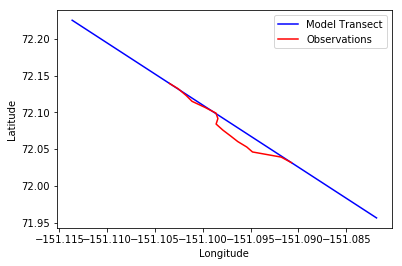

In [8]:
# Get offset for y
y_offset = L['y']/2 - ds['y'][-1]/2
# Interp/Extrap to lat, lon coordinates
f_lat = interpolate.interp1d([ds['y'][0], ds['y'][-1]] + y_offset,[ds['lat'][0], ds['lat'][-1]],\
                                   fill_value="extrapolate")
f_lon = interpolate.interp1d([ds['y'][0], ds['y'][-1]] + y_offset,[ds['lon'][0], ds['lon'][-1]],\
                                   fill_value="extrapolate")
ll = {'lat':f_lat(y['C']), 'lat_G':f_lat(y['G']), 'lon':f_lon(y['C']), 'lon_G':f_lon(y['G'])}

plt.plot(ll['lon'],ll['lat'],'b',ds['lon'],ds['lat'],'r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(('Model Transect','Observations'))
plt.show()

## Calculate full Temperature and Salinity fields

The front is assumed to have the form $$b(y,z) = \frac{\Delta B}{4} \tanh(\frac{z+H1}{dh}+1) \tanh(\frac{y-\frac{L_y}{2}}{L_f}+1)$$

In [9]:
# Define function that approximates mixed layer front
def MLfront(z,y,L,L_f,dh,H,dB):
    # Calculates 2-D surface mixed layer front
    y, z = np.meshgrid(y,z)
    return (dB/4)*(np.tanh((z+H)/dh)+1)*(np.tanh((y-(L/2))/L_f)+1)

In [10]:
# Make model fields that are uniform laterally
# Absolute Salinity
S = {'vertonly': np.tile(np.reshape(S_func(z['C'],*popt_S),(-1,1)),(1,y['C'].size))}
S['vertonly_G'] = np.tile(np.reshape(S_func(z['C'],*popt_S),(-1,1)),(1,y['G'].size))
# Conservative Temperature
T = {'vertonly': np.tile(np.reshape(T_func(z['C'],*popt_T),(-1,1)),(1,y['C'].size))}
T['vertonly_G'] = np.tile(np.reshape(T_func(z['C'],*popt_T),(-1,1)),(1,y['G'].size))

# Force mixed layer to be uniform
i_uni = np.argmax(z['C'] <= -3)
# Absolute Salinity
S['vertonly'][z['C'] > -3,:] = S['vertonly'][i_uni,0]
S['vertonly_G'][z['C'] > -3,:] = S['vertonly_G'][i_uni,0]
# Conservative Temperature
T['vertonly'][z['C'] > -3,:] = T['vertonly'][i_uni,0]
T['vertonly_G'][z['C'] > -3,:] = T['vertonly_G'][i_uni,0]

# Make model fields that only contain front
# Absolute Salinity
S['frontonly'] = MLfront(z['C'],y['C'],L['y'],Lf,dh,H1,dS)
S['frontonly_G'] = MLfront(z['C'],y['G'],L['y'],Lf,dh,H1,dS)
# Conservative temperature
T['frontonly'] = MLfront(z['C'],y['C'],L['y'],Lf,dh,H1,dT)
T['frontonly_G'] = MLfront(z['C'],y['G'],L['y'],Lf,dh,H1,dT)

# Full fields
# Absolute Salinity
S['SA'] = S['vertonly'] + S['frontonly']
S['SA_G'] = S['vertonly_G'] + S['frontonly_G']
# Conservative Temperature
T['CT'] = T['vertonly'] + T['frontonly']
T['CT_G'] = T['vertonly_G'] + T['frontonly_G']

## Compare Observations and Approximate Fields

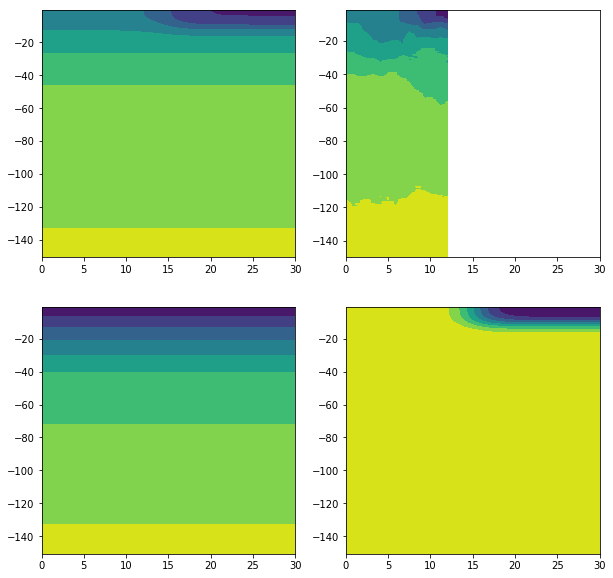

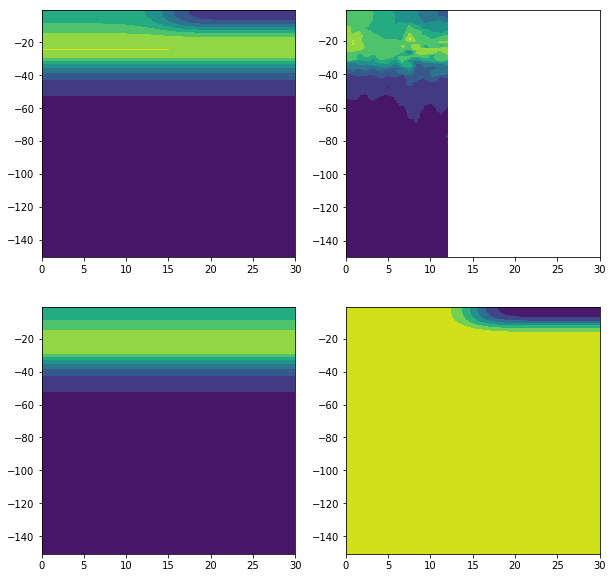

In [11]:
# Absolute Salinity
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1,xlim=(0,L['y']))
ax2 = fig.add_subplot(2,2,2, sharex=ax1)
ax3 = fig.add_subplot(2,2,3, sharex=ax1)
ax4 = fig.add_subplot(2,2,4, sharex=ax1)
# Full approximation
ax1.contourf(y['G'],z['C'],S['SA_G'])

# Observed Salinity
ax2.contourf(ds['y'],ds['z'],ds['SA'])

# Vertical only
ax3.contourf(y['G'],z['C'],S['vertonly_G'])

# Front only
ax4.contourf(y['G'],z['C'],S['frontonly_G'])

plt.show()


# Conservative Temperature
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1,xlim=(0,L['y']))
ax2 = fig.add_subplot(2,2,2, sharex=ax1)
ax3 = fig.add_subplot(2,2,3, sharex=ax1)
ax4 = fig.add_subplot(2,2,4, sharex=ax1)
# Full approximation
ax1.contourf(y['G'],z['C'],T['CT_G'])

# Observed Temperature
ax2.contourf(ds['y'],ds['z'],ds['CT'])

# Vertical only
ax3.contourf(y['G'],z['C'],T['vertonly_G'])

# Front only
ax4.contourf(y['G'],z['C'],T['frontonly_G'])

plt.show()

## Test density for static stability

In [12]:
# Calc potential density referenced to the surface
sigma0 = gsw.sigma0(S['SA'],T['CT'])
# Calculate N2
N2, z['N2'] = gsw.Nsquared(S['SA'],T['CT'],np.tile(-z['C'].reshape(-1,1),(1,N['y'])))

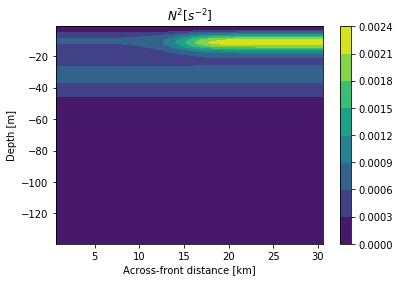

In [13]:
plt.contourf(np.tile(y['C'],(N['z']-1,1)),-z['N2'],N2)
plt.colorbar()
plt.title('$N^2 [s^{-2}]$')
plt.xlabel('Across-front distance [km]')
plt.ylabel('Depth [m]')
plt.show()

In [14]:
# Estimate baroclinic mixed layer Rossby radius
# Calculate Coriolis frequency
f = gsw.f(ll['lat'].mean())
# Get N_bar over H1
N_bar = np.sqrt(N2[z['N2'] < H1].mean())
# Estimate R
R_ros = N_bar * H1/(f*1000)
print(R_ros)

2.1395967207724236


## Calculate geostrophic velocities and sea surface height
Use the TEOS-10 gsw toolbox

In [15]:
# Calc the dynamic height anomaly
dyn_H = gsw.geo_strf_dyn_height(S['SA_G'],T['CT_G'],-z['C'],-z['C'][-1])
# Get u_geostrophic
u_geo = gsw.geostrophic_velocity(dyn_H,ll['lon_G'],ll['lat_G'])
# Remove noise
u_noise = 1e-6
u_geo = np.where(u_geo[0] < u_noise, 0, u_geo[0])

# Calculate sea surface height
# Calc insitu density
rho = gsw.rho(S['SA'],T['CT'],np.tile(-z['C'].reshape(-1,1),(1,N['y'])))
# Isolate density at the surface
rho_0_inv = 1/rho[0,:]
# Get mean density as a function of depth
rho_ybar = np.tile(((rho[:,0]+rho[:,-1])/2).reshape(-1,1),(1,N['y']))
# Inegrate density for eta
eta = rho_0_inv * np.trapz(rho - rho_ybar,z['C'],axis=0)

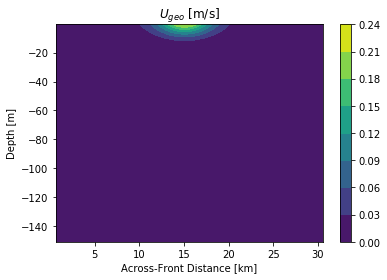

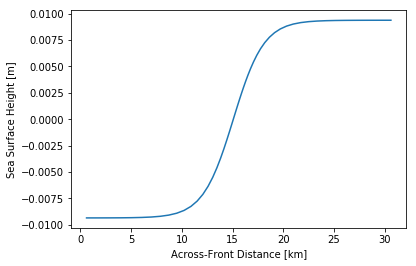

In [16]:
# Plot
plt.contourf(y['C'],z['C'],u_geo)
plt.colorbar()
plt.ylabel('Depth [m]')
plt.xlabel('Across-Front Distance [km]')
plt.title('$U_{geo}$ [m/s]')
plt.show()

plt.plot(y['C'],eta)
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Sea Surface Height [m]')
plt.show()

## Calculate required viscosity and timestep

In [17]:
# Required grid scale viscosity
nu_min = (L['x']/N['x']) * u_geo
print(nu_min.max())

# Required time step
dt = (L['x']/N['x']) / u_geo.max()
print(dt)

0.04376346423494473
0.9140044258210337


In [18]:
# Add x-dimesion to data
# Temperature
CT = copy(T['CT'].T)
# Set walls to zero
# CT[0,:] = 0
# CT[-1,:] = 0
# Replicate into 3-D
CT = np.tile(CT.reshape(1,N['y'],N['z']),(N['x'],1,1))

# Salinity
SA = copy(S['SA'].T)
# Set walls to zero
# SA[0,:] = 0
# SA[-1,:] = 0
# Replicate into 3-D
SA = np.tile(SA.reshape(1,N['y'],N['z']),(N['x'],1,1))

# Velocity
UU = copy(u_geo.T)
# Set walls to zero
UU[0,:] = 0
UU[-1,:] = 0
# Replicate into 3-D
UU = np.tile(UU.reshape(1,N['y'],N['z']),(N['x'],1,1))

# Eta
Eta = copy(eta.T)
Eta = np.tile(Eta.reshape(1,N['y']),(N['x'],1))

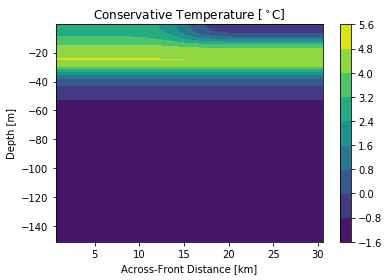

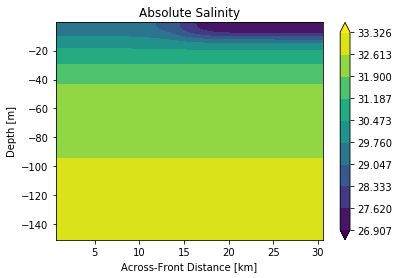

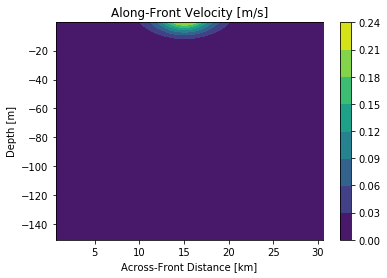

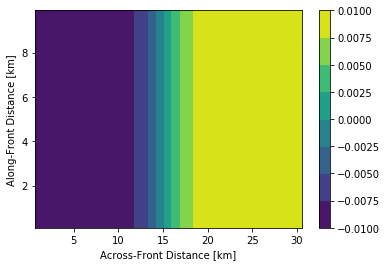

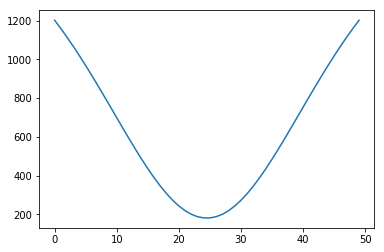

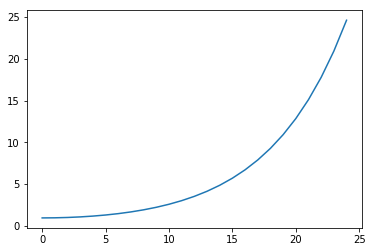

In [19]:
# Plot slices to check that its still good data
# Temperature
plt.contourf(y['C'],z['C'],CT[0,:,:].T)
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Depth [m]')
plt.title('Conservative Temperature [$^\circ$C]')
plt.colorbar()
plt.show()

# Salinity
plt.contourf(y['C'],z['C'],SA[0,:,:].T,np.linspace(S['SA'].min(),S['SA'].max(),10),extend='both')
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Depth [m]')
plt.title('Absolute Salinity')
plt.colorbar()
plt.show()

# Velocity
plt.contourf(y['C'],z['C'],UU[0,:,:].T)
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Depth [m]')
plt.title('Along-Front Velocity [m/s]')
plt.colorbar()
plt.show()

# Eta
plt.contourf(y['C'],x['C'],Eta)
plt.xlabel('Across-Front Distance [km]')
plt.ylabel('Along-Front Distance [km]')
plt.colorbar()
plt.show()

# delY
plt.plot(delY)
plt.show()

# delZ
plt.plot(delZ)
plt.show()

In [20]:
# Make bottom topography
z_bot = z['G'][-1] * np.ones((N['x'],N['y']))
# Make southern and northern walls
z_bot[:,0] = 0
z_bot[:,-1] = 0

## Write variables to binary files

In [21]:
# Write approximated observations to binary files
# Make directory for set up
dataout = datapath + 'gcm_input/Lx%03dLy%03dLz%03d_Nx%03dNy%03dNz%03d/' % \
(L['x'], L['y'], L['z'], N['x'], N['y'], N['z'])
os.mkdir(dataout)

# delY
delY.astype(tp).tofile(dataout + 'dy.bin')

# delZ
delZ.astype(tp).tofile(dataout + 'dz.bin')

# Topo
z_bot.astype(tp).tofile(dataout + 'topog.bin')

# Temperature
CT.astype(tp).tofile(dataout + 'theta.bin')

# Salinity
SA.astype(tp).tofile(dataout + 'salt.bin')

# Velocity
UU.astype(tp).tofile(dataout + 'uvel.bin')

# SSH
Eta.astype(tp).tofile(dataout + 'eta.bin')